In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import igraph
import networkx as nx

from helpers.linkage import *
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
import seaborn as sns
from helpers.networks import *
import helpers.style as style
import datetime

from networkx.algorithms.community import quality
from networkx.algorithms.assortativity import average_degree_connectivity,average_neighbor_degree
import networkx.algorithms.community as nx_comm
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from sklearn.metrics import mean_squared_error

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dists = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/dists-speech-bound-250',sep='\t')
data = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/data-speech-level-full.tsv',sep='\t')   

In [3]:
# ## Load Metadata
# mtd = pd.read_csv('/home/rb/Documents/Data/metadata/session-metadata.tsv', sep='\t')
# dates = pd.read_csv('/home/rb/Documents/Data/metadata/dates.csv')
# dates = dict(zip(dates.id.str.split('.').str[4], pd.to_datetime(dates.date, infer_datetime_format=True)))
# mtd['date'] = mtd.session.map(dates.get).apply(lambda d: pd.Timestamp(year=d.year, month=1 if d.month < 7 else 6, day=1))

# mtd = mtd[(mtd.house == 'commons') & (mtd.date.dt.year > 1945)]
# mtdd = dict(zip(mtd.session, mtd.type))


# data['sesstype'] = data.speech_id.str.split('.').str[4].apply(lambda x: mtdd.get(x))
# data = data[data.sesstype == 'plenary']
# dists = dists.loc[data.index]

In [4]:
dists.index = pd.to_datetime(data.date,infer_datetime_format=True)
del data
dists = {pd.Timestamp(year=y,month=1 if h == 0 else 6,day=1):_.to_numpy() for (y,h),_ in dists.groupby([dists.index.year,(dists.index.month-1)//6]) if len(_) > 25}
# dists = {q:_.to_numpy() for q,_ in dists.groupby(dists.index.to_period('Q')) if len(_) > 100}

# Network (Community) Statistics with Different _Weight Filter_ Thresholds

In [5]:
diag = []
edges = []
memberships = []

for c,(d,mi) in tqdm(enumerate(dists.items())):
    mi,_,__ = mutual_information(mi,topn=None)
    g,comm,df = get_network_from_mi_theta(mi_theta=mi,weighted=False,cluster_method='louvain',weight_threshold=0)

    df['p'] = d
    edges.append(df)
    memberships.append(dict(zip([i['name'] for i in g.vs], comm.membership)))

    g_nx = g.to_networkx()
    g_nx_comm = nx_comm.louvain_communities(g_nx)
    pq = quality.partition_quality(G=g_nx,partition=g_nx_comm)
    mod = quality.modularity(G=g_nx,communities=g_nx_comm)
    btw = igraph.mean(g.betweenness())
    apl = nx.average_shortest_path_length(g_nx)
    clustering_coefficient = nx.average_clustering(g_nx)
    network_density = nx.density(g_nx)

    ## MSE of Log(DEG) / Log(BTW) Regression
    # x = [np.log(i[1]) if i[1] != np.inf else np.nan for i in get_betweenness_values(g)]
    # y = [np.log(i[1]) if i[1] != np.inf else np.nan for i in get_degree_values(g)]
    # x = [i if i != -np.inf else 0 for i in x]
    # y = [i if i != -np.inf else 0 for i in y]
    # lr = LinearRegression()
    # lr.fit(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))
    # wgt = lr.coef_[0]
    # itc = lr.intercept_
    # pred = [i * wgt + itc for i in x]
    # mse = mean_squared_error(y,pred)

    diag.append({"date":d,"performance":pq[0],"coverage":pq[1],"modularity":mod,"btw":btw,"apl":apl,"cc":clustering_coefficient,"density":network_density})
diag = pd.DataFrame(diag)

91it [02:04,  1.37s/it]


array([[<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>],
       [<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>],
       [<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>],
       [<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>]],
      dtype=object)

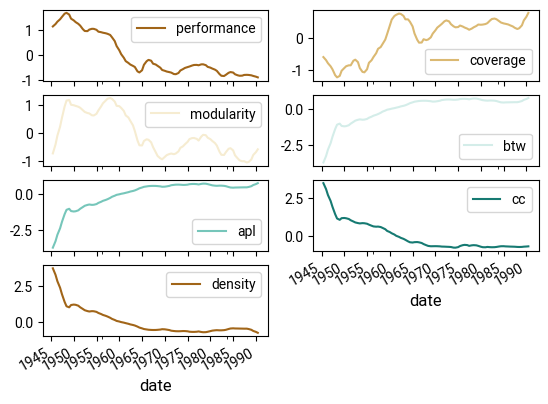

In [6]:
diag.set_index('date').apply(zscore).apply(adaptive_filter,span=35).plot(subplots=True,layout=(4,2))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


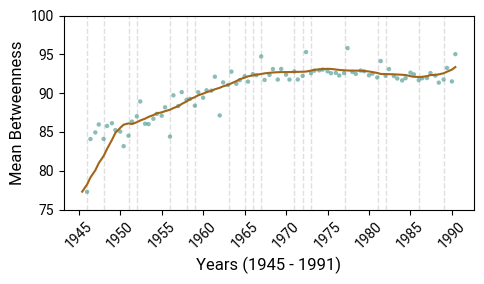

In [35]:
fig,ax = plt.subplots(1,1,figsize=(5,3))

X = diag.date
Y = diag.btw

ax.scatter(X,Y,c=sns.color_palette('BrBG')[-1],alpha=.5,marker='o',ec=None,s=10)
ax.plot(X,adaptive_filter(Y,span=25))


ax.tick_params(axis='x',labelrotation=45)
ax.set_ylabel(r'Mean Betweenness')
ax.set_xlabel(r'Years (1945 - 1991)')
ax.set_ylim(75,100)
add_cabinet_periods(ax,text=False,color='grey',max_time=1994,alpha=.25)

fig.tight_layout()
plt.savefig('figs/btw-diachronic-speech-level.png',dpi=250,bbox_inches='tight')
plt.show()

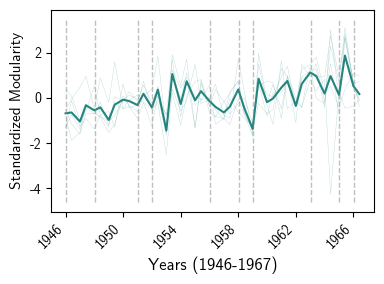

In [16]:
# fig,ax = plt.subplots(1,1,figsize=(4,3))

# for wf,g in diagz.groupby('wf'):
#     ax.plot(g.date,g.modularity,color=sns.color_palette('BrBG',5)[-1],alpha=.35,lw=.25)

# diagz[['date','modularity']].groupby('date').mean().reset_index().plot(x='date',y='modularity',ax=ax,color=sns.color_palette('BrBG',5)[-1],linewidth=1.5,legend=False)

# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
# ax.set_ylabel('Standardized Modularity',fontsize=11)
# ax.set_xlabel('Years (1946-1967)')

# years = YearLocator()
# yearsFmt = DateFormatter('%Y')
# ax = plt.gca()
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.autoscale_view()
# ax.set_xticks([datetime.date(y,1,1) for y in range(1946,1967,4)])
# add_cabinet_periods(ax,text=False,color='grey',max_time=1966)
# ax.tick_params(axis='x',labelrotation=45)


# fig.tight_layout()
# plt.savefig('figs/network-modularity-bootstrapped-weight-filter.pdf',dpi=250,bbox_inches='tight')
# plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


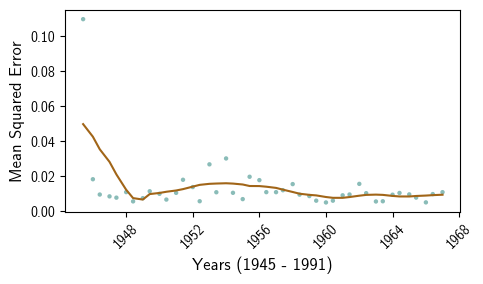

In [39]:
# fig,ax = plt.subplots(1,1,figsize=(5,3))

# X = diag.date
# Y = diag.mse

# ax.scatter(X,Y,c=sns.color_palette('BrBG')[-1],alpha=.5,marker='o',ec=None,s=10)
# ax.plot(X,diag.mse_afa)

# ax.tick_params(axis='x',labelrotation=45)
# ax.set_ylabel(r'Mean Squared Error')
# ax.set_xlabel(r'Years (1945 - 1991)')

# fig.tight_layout()
# # plt.savefig('/home/rb/Desktop/mse-diachronic-speech-level.png',dpi=250,bbox_inches='tight')
# plt.show()

In [14]:
timestamps = sorted(list(dists.keys()))

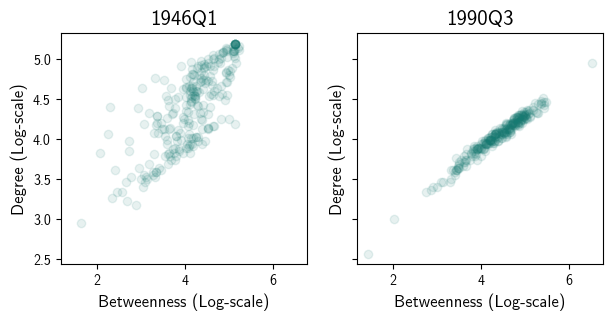

In [25]:
fig,ax = plt.subplots(1,2,figsize=(7,3),sharex=True,sharey=True)

for c,i in enumerate([0,-1]):
    mi = dists[timestamps[i]]
    mi,_,__ = mutual_information(mi,topn=None)
    g,comm,df = get_network_from_mi_theta(mi_theta=mi,weight_threshold=0)
    x = [np.log(i[1]) for i in get_betweenness_values(g)]
    y = [np.log(i[1]) for i in get_degree_values(g)]
    ax[c].scatter(x,y,color=sns.color_palette('BrBG')[-1],alpha=.1)
    ax[c].set_title(timestamps[i],fontsize=15)
    ax[c].set_xlabel('Betweenness (Log-scale)')
    ax[c].set_ylabel('Degree (Log-scale)')

plt.savefig('/home/rb/Desktop/btw-deg-scatters.png',dpi=400,transparent=False,bbox_inches='tight')
plt.show()

In [43]:
print(time)

1950Q1


In [23]:
def plot(dists,ax,time):
    theta = dists[time]
    mi,_,__ = mutual_information(theta,topn=5)
    g,comm,df = get_network_from_mi_theta(mi_theta=mi,weight_threshold=0,dis_filter=.96)
    sizes = pd.DataFrame(theta).mean().to_dict()
    # df = df[(df.source.isin([i for i,l in labels.items() if 'rhet' not in l and 'proc' not in l and 'nonse' not in l])) & (df.target.isin([i for i,l in labels.items() if 'rhet' not in l and 'proc' not in l and 'nonse' not in l]))]
    g = nx.from_pandas_edgelist(df = df, source = 'source', target = 'target', edge_attr = 'weight')
    lo = nx.spring_layout(g, k=0.5, iterations=100)
    gc = nx_comm.louvain_communities(g)

    pal = sns.color_palette('BrBG',250)
    colors = {i:pal[i] for i in range(250)}
    nx.draw_networkx_edges(g,lo,width=1,ax=ax)

    for node, pos in lo.items():
        ax.annotate(text=int(node),
                    xy=pos,
                    color='white' if int(node) not in range(100,150) else 'black',
                    bbox=dict(facecolor=colors[int(node)],
                    boxstyle='circle'),
                    fontsize=abs(np.log2(sizes[node])),
                    ha='center',
                    va='center')
        
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    return g, gc

/home/rb/Documents/GitHub/linkage/helpers/networks.py:122: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:123: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:124: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("variance_max", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:122: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:123: FutureWarning: In a future version o

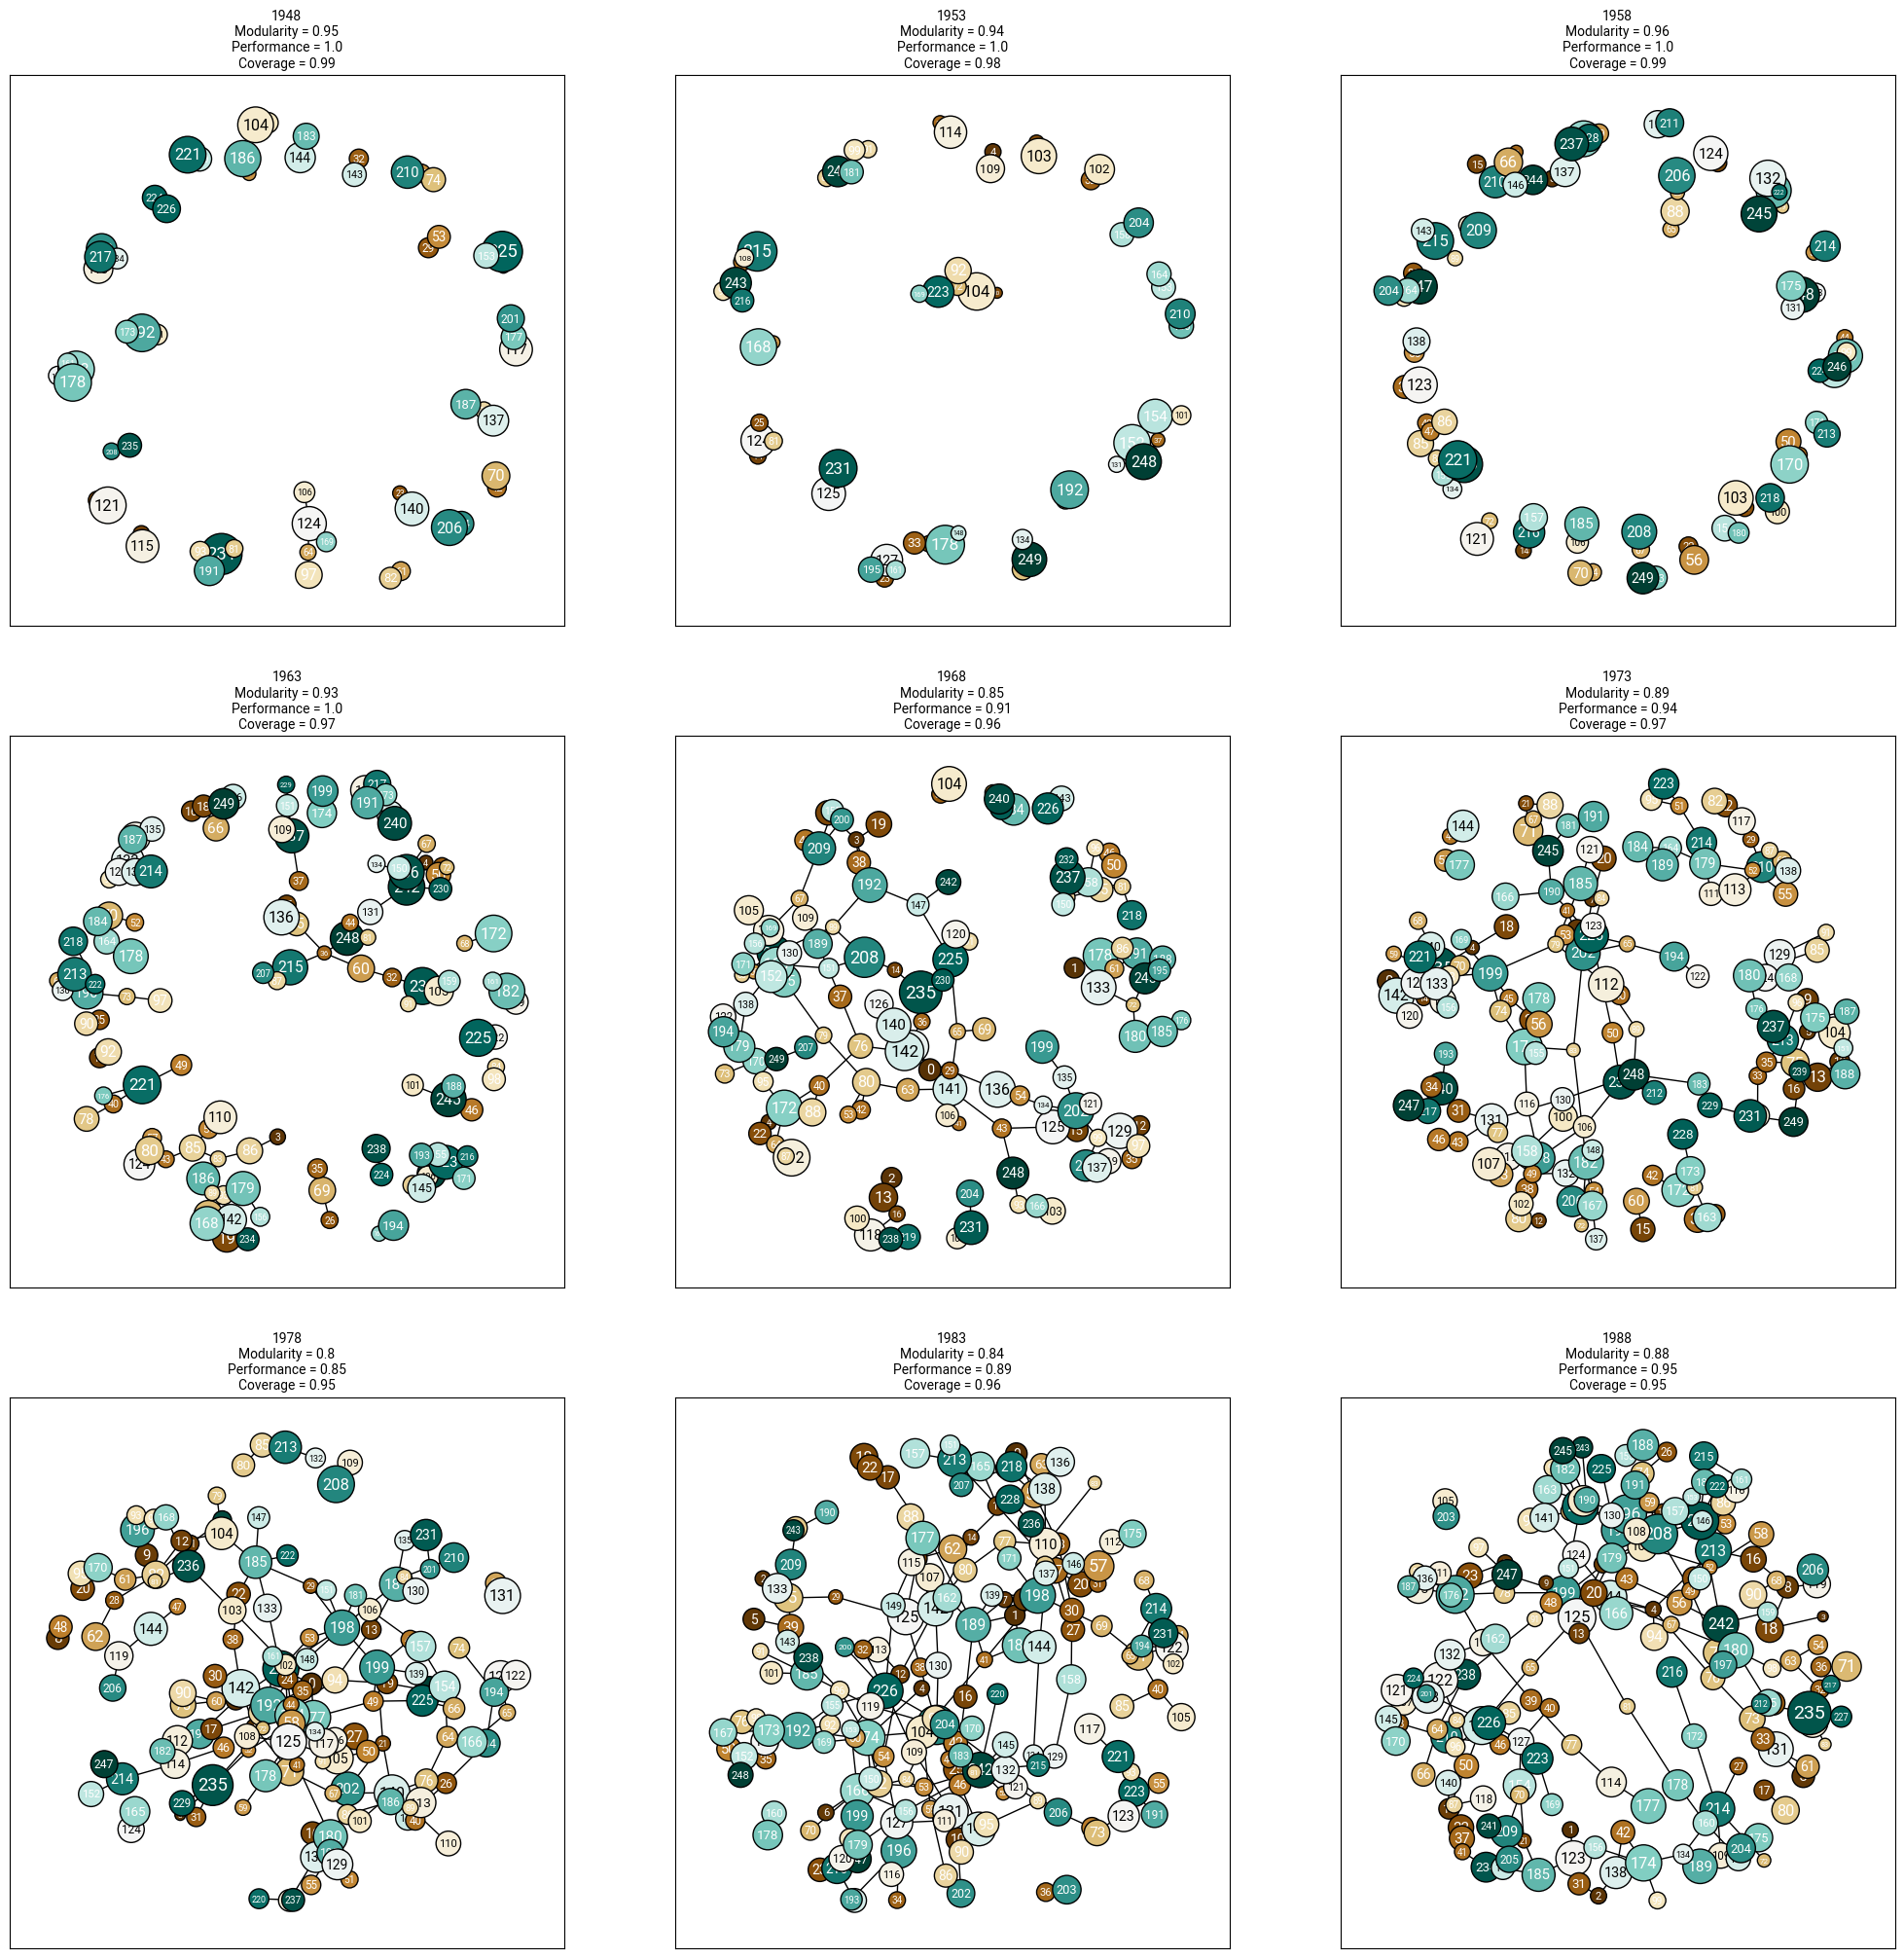

In [24]:
fig,ax = plt.subplots(3,3,figsize=(25,25))

ts = sorted(list(dists.keys()))
for c,t in enumerate(range(5,86,10)):
    g,gc = plot(dists,ax.flatten()[c],ts[t])
    pq = quality.partition_quality(G=g,partition=gc)
    mod = quality.modularity(G=g,communities=gc)
    ax.flatten()[c].set_title(f"{ts[t].year}\nModularity = {round(mod,2)}\nPerformance = {round(pq[0],2)}\nCoverage = {round(pq[1],2)}")

In [1]:
import manim

NameError: name 'Scene' is not defined